In [9]:
# Importing essential libraries for data processing and analysis
import pandas as pd
import numpy as np

In [10]:
# Load dataset
data = pd.read_csv("data/T1.csv")

# Display first few rows
data.head()

# Check dataset shape (rows, columns)
data.shape

# Check for missing values
data.isnull().sum()

# Display column names
data.columns


Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
      dtype='object')

In [11]:
# Remove rows with missing values
data.dropna(inplace=True)

# Select only required columns
data = data[['Wind Speed (m/s)', 'Wind Direction (°)', 'LV ActivePower (kW)']]

# Remove invalid negative power output values
data = data[data['LV ActivePower (kW)'] >= 0]

# Save cleaned dataset
data.to_csv("data/cleaned_data.csv", index=False)

print("Data cleaning and preprocessing completed.")

Data cleaning and preprocessing completed.


In [12]:
# Independent variables (features)
X = data[['Wind Speed (m/s)', 'Wind Direction (°)']]

# Dependent variable (target)
y = data['LV ActivePower (kW)']

In [13]:
# Import libraries for model building
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import joblib

In [14]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
# Train a lightweight Random Forest model
model = RandomForestRegressor(
    n_estimators=80,      # increase number of trees
    max_depth=18,         # deeper trees
    min_samples_split=4,  # control overfitting
    random_state=42,
    n_jobs=-1
)

# Train the model
model.fit(X_train, y_train)

print("Model training completed.")

Model training completed.


In [16]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate R2 Score
r2 = r2_score(y_test, y_pred)

print("R2 Score:", r2)

R2 Score: 0.9108731016393556


In [17]:
# Save the trained model for future use
joblib.dump(model, "wind_energy_model.pkl", compress=1)

print("Model saved successfully.")

Model saved successfully.


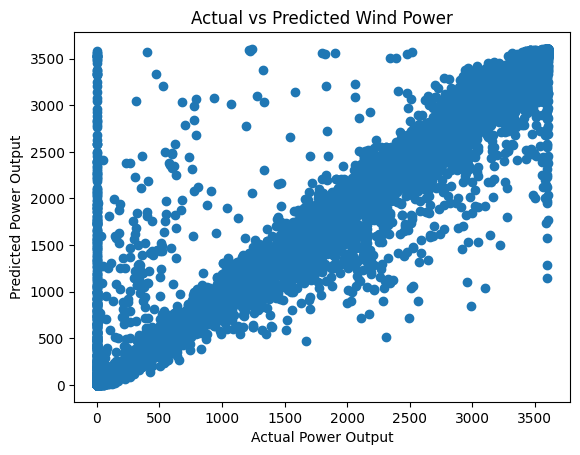

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Power Output")
plt.ylabel("Predicted Power Output")
plt.title("Actual vs Predicted Wind Power")
plt.savefig("actual_vs_predicted.png")
plt.show()

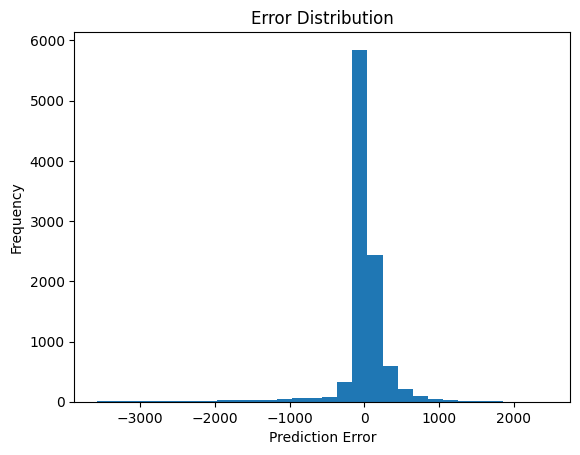

In [19]:
errors = y_test - y_pred

plt.figure()
plt.hist(errors, bins=30)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.savefig("error_distribution.png")
plt.show()

In [20]:
# Install Streamlit for application building
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 129.2 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.0
    Uninstalling cachetools-7.0.0:
      Successfully uninstalled cachetools-7.0.0


In [63]:
%%writefile app.py
import streamlit as st
import joblib
import numpy as np
import requests
import os

# Load trained model
model = joblib.load("wind_energy_model.pkl")

st.set_page_config(page_title="Wind Energy Prediction", layout="wide")

# ---------- SESSION STATE ----------
if "page" not in st.session_state:
    st.session_state.page = "home"

# ---------- WELCOME PAGE ----------
if st.session_state.page == "home":

    st.markdown("<h1 style='text-align:center;'>🌬 Wind Mill Power Prediction</h1>", unsafe_allow_html=True)
    st.markdown("<h4 style='text-align:center;'>Predict the energy output of windmills using Machine Learning</h4>", unsafe_allow_html=True)

    col1, col2 = st.columns(2)

    with col1:
        st.info("🌤 Weather Forecast\n\nGet real-time weather data for selected cities")

    with col2:
        st.info("⚡ Power Prediction\n\nPredict wind turbine energy output using ML")

    if st.button("Get Started ➜"):
        st.session_state.page = "weather"

# ---------- WEATHER PAGE ----------
elif st.session_state.page == "weather":

    st.header("🌤 Weather & ⚡ Power Prediction")

    city_list = [
        "Mumbai", "Delhi", "Hyderabad", "Chennai", "Bangalore",
        "Kolkata", "Pune", "Ahmedabad", "Visakhapatnam", "Vijayawada",
        "Tirupati", "Kakinada", "Rajahmundry", "London", "New York", "Tokyo"
    ]

    col_left, col_right = st.columns(2)

    # -------- LEFT: WEATHER --------
    with col_left:
        st.subheader("🌤 Weather Forecast")

        city = st.selectbox("Select City", city_list)

        if st.button("Get Weather"):

            API_KEY = os.getenv("OPENWEATHER_API_KEY")
            if not API_KEY:
              st.error("API key not found. Please set environment variable.")
              st.stop()
            url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&units=metric"

            try:
                response = requests.get(url, timeout=10)
                data = response.json()

                if response.status_code == 200:

                    temp = data["main"]["temp"]
                    humidity = data["main"]["humidity"]
                    pressure = data["main"]["pressure"]
                    wind_speed = data["wind"]["speed"]
                    wind_direction = data["wind"]["deg"]  # ✅ FIXED

                    st.success(f"Weather Data for {city}")

                    st.metric("🌡 Temperature", f"{temp} °C")
                    st.metric("💧 Humidity", f"{humidity} %")
                    st.metric("ضغط Pressure", f"{pressure} hPa")
                    st.metric("🌬 Wind Speed", f"{wind_speed} m/s")
                    st.metric("🧭 Wind Direction", f"{wind_direction} °")

                    # Save values for prediction
                    st.session_state.wind_speed = wind_speed
                    st.session_state.wind_direction = wind_direction

                else:
                    st.error(data.get("message", "Weather data not found"))

            except Exception as e:
                st.error("API request failed")
                st.write(e)

    # -------- RIGHT: PREDICTION --------
    with col_right:
        st.subheader("⚡ Wind Power Prediction")

        wind_speed = st.number_input(
            "Wind Speed (m/s)",
            value=st.session_state.get("wind_speed", 5.0)
        )

        wind_direction = st.number_input(
            "Wind Direction (°)",
            value=st.session_state.get("wind_direction", 0.0)
        )

        if st.button("Predict Power"):

            input_data = np.array([[wind_speed, wind_direction]])
            prediction = model.predict(input_data)

            st.success(f"Predicted Power Output: {prediction[0]:.2f} kW")

    st.markdown("---")

    if st.button("⬅ Back to Home"):
        st.session_state.page = "home"


Overwriting app.py


In [30]:
# Install ngrok for Public URL

!pip install pyngrok

In [34]:
# Configure ngrok

from pyngrok import ngrok

# setting ngrok auth token
ngrok.set_auth_token("ENTER_YOUR_NGROK_TOKEN")

In [64]:
# Generate public URL
public_url = ngrok.connect(8501)
print(public_url)

NgrokTunnel: "https://zain-flamless-sighingly.ngrok-free.dev" -> "http://localhost:8501"


In [65]:
# Run and Test Application

!streamlit run app.py &




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.157.91:8501

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


  Stopping...


In [51]:
!pkill streamlit


In [67]:
%%writefile requirements.txt
pandas
numpy
scikit-learn
streamlit
joblib
requests

Overwriting requirements.txt


In [68]:
%%writefile README.md
# 🌬️ Wind Energy Prediction Using Machine Learning

## 📌 Project Overview

This project predicts wind turbine power output based on weather parameters using a **Random Forest Regression** model.
It integrates **real-time weather data** using the **OpenWeatherMap API** and provides an interactive **Streamlit web application** with a modern user interface.

The system demonstrates how machine learning can be applied to renewable energy forecasting and efficient power management.

---

## 🎯 Features

* 📊 Wind turbine power prediction using machine learning
* 🌤 Real-time weather data integration (OpenWeatherMap API)
* 🧭 Automatic wind speed and wind direction input for prediction
* 🖥 Multi-page Streamlit interface (Welcome → Weather → Prediction)
* 📈 Model evaluation using regression metrics and graphs
* 🔐 Secure API key using environment variables

---

## 🧠 Machine Learning Workflow

1. Data collection from Kaggle (Wind Turbine SCADA dataset)
2. Data preprocessing and feature selection
3. Train–test split
4. Model training using **Random Forest Regressor**
5. Model evaluation using MAE, RMSE, and R² Score
6. Model saved as `wind_energy_model.pkl`
7. Deployment using Streamlit

---

## 📂 Project Structure

```
wind-energy-prediction/
│
├── data/
│   ├── T1.csv
│   └── cleaned_data.csv
│
├── images/
│   ├── actual_vs_predicted.png
│   └──error_distribution.png
│
│
├── app.py
├── wind_energy_model.pkl
├── requirements.txt
├── README.md
└── notebook/
    └── wind_energy_prediction.ipynb
```

---

## 🌤 Real-Time Weather Integration

Weather data is fetched using the **OpenWeatherMap API**.
The application automatically extracts:

* Temperature
* Humidity
* Pressure
* Wind Speed
* Wind Direction

Wind parameters are directly passed to the machine learning model for power prediction.

---

## 🖥 Streamlit Application Flow

1. **Welcome Page** – Project introduction
2. **Weather Section** – Select a city and fetch live weather data
3. **Prediction Section** – Auto-filled wind parameters used to predict power output

---

## ⚙️ Installation & Setup

### 1️⃣ Clone the Repository

```bash
git clone https://github.com/your-username/wind-energy-prediction.git
cd wind-energy-prediction
```

### 2️⃣ Install Dependencies

```bash
pip install -r requirements.txt
```

### 3️⃣ Set OpenWeatherMap API Key

#### ▶️ Linux / Mac

```bash
export OPENWEATHER_API_KEY="your_api_key_here"
```

#### ▶️ Windows (PowerShell)

```powershell
setx OPENWEATHER_API_KEY "your_api_key_here"
```

---

### 4️⃣ Run the Streamlit App

```bash
streamlit run app.py
```

---

## 📚 Dataset

Wind Turbine SCADA Dataset from Kaggle
https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset

---

## 🧪 Technologies Used

* Python
* Pandas
* NumPy
* Scikit-learn
* Matplotlib
* Streamlit
* OpenWeatherMap API
* Joblib

---

## 🎓 Academic Relevance

This project demonstrates:

* Regression modeling for renewable energy
* Data preprocessing and feature selection
* Model evaluation using statistical metrics
* Real-time API integration
* Interactive machine learning deployment

---

## 🚀 Future Enhancements

* Real-time SCADA data integration
* Deep learning models for time-series forecasting
* Cloud deployment using Streamlit Cloud or Render
* Historical prediction visualization

---

## 👨‍💻 Author

**Adireddy Chaitanya**
B.Tech – Electronics and Communication Engineering
Chaitanya Institute of Science and Technology

---

## 📜 License

This project is developed for academic and educational purposes.

Overwriting README.md


In [69]:
# Verify all required files
!ls
!ls data

app.py	images	   requirements.txt  wind_energy_model.pkl
data	README.md  sample_data
cleaned_data.csv  T1.csv
